![DCGan1](../img/dcgan/dcgan1.png)
![DCGan-discriminator](../img/dcgan/dcgan-discriminator.png)
The discriminator is the “art critic,” who tries to distinguish between real and fake images. Simply said, this is a convolutional neural network for image classification.

-->The discriminator network consists of three convolutional layers

-->For every layer of the network, we are going to perform a convolution, then we are going to perform batch normalization to make the network faster and more accurate, and, finally, we are going to perform a Leaky ReLu to further speed up the training.

-->At the end, we flatten the output of the last layer and use the sigmoid activation function to get a classification. We now have a prediction whether the image is real or not.

![DCGan-generator](../img/dcgan/dcgan-generator.png)
The generator goes the other way: It is the “artist” who is trying to fool the discriminator.

-->The generator makes use of deconvolutional layers. They are the exact opposite of a convolutional layers: Instead of performing convolutions until the image is transformed into simple numerical data, such as a classification, we perform deconvolutions to transform numerical data into an image.

-->This is a concept which is not as known as a simple convolutional layer

-->we are doing the same thing as the discriminator, just in the other direction. First, we take our input, called Z, and feed it into our first deconvolutional layer. Each deconvolutional layer performs a deconvolution and then performs batch normalization and a leaky ReLu as well. Then, we return the tanh activation function.

In [12]:
#

from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Import MNIST data

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../mnist', one_hot=True)

from keras import backend as K
#Clear TF memory
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

Extracting ../mnist\train-images-idx3-ubyte.gz
Extracting ../mnist\train-labels-idx1-ubyte.gz
Extracting ../mnist\t10k-images-idx3-ubyte.gz
Extracting ../mnist\t10k-labels-idx1-ubyte.gz


In [2]:
mnist.train.labels

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [3]:
mnist.train.images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [4]:
#Training Param
num_steps = 10000
batch_size = 128
lr_generator = 0.002
lr_discriminator = 0.002

#Network Params
image_dim = 784 #28*28 shape *1 channel
noise_dim = 100 #Noise data points

In [5]:
#Build Networks
#Network Inputs
noise_input = tf.placeholder(dtype=tf.float32, shape=[None, noise_dim])
real_image_input = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1])

#A boolean to indicate batch normalization if it is training or inference time
is_training = tf.placeholder(dtype=tf.bool)

#LeakyRelu activation
def leakyrelu(x, alpha=0.2):
    return 0.5 * (1+alpha) * x + 0.5 * (1-alpha) * abs(x)

In [6]:
#Generator Network
#Input: Noise, Ouput: Image
#Note that batch normalization has different behavior at training and inference time,
#we then use a placeholder to indicates the layer if we are training or not
def generator(x, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        #TF layers automatically create variables and calculate their shape, based on the input
        x = tf.layers.dense(x, units=7*7*128)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.nn.relu(x)
        
        #Reshape to a 4-D array of images (batch, height, width, channels)
        #New shape: (batch, 7, 7, 128)
        x = tf.reshape(x, shape=[-1, 7, 7, 128])
        
        #Deconvolution, image shape: (batch, 14, 14, 64)
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding='SAME')
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.nn.relu(x)
        
        #Deconvolution, image shape: (batch, 28, 28, 1)
        x = tf.layers.conv2d_transpose(x, 1, 5, strides=2, padding='SAME')
        
        #Apply tanh for better stability - clip values to [-1,1]
        x = tf.nn.tanh(x)
        return x

In [7]:
#Discriminator Network
#Input: Image, Output: Prediction Real/Fake Image
def discriminator(x, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        #Typical convolution neural network to classify images
        x = tf.layers.conv2d(x, 64, 5, strides=2, padding='SAME')
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='SAME')
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        
        #Flatten
        x = tf.reshape(x, shape=[-1, 7*7*128])
        x = tf.layers.dense(x, 1024)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        
        #Output 2 classes: Real and Fake images
        x = tf.layers.dense(x, 2)
    return x

In [8]:
#Build Generator Network
gen_sample = generator(noise_input)

#Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(real_image_input)       #one from noise input
disc_fake = discriminator(gen_sample, reuse=True) #one from generated samples

#Build the stacked generator/discriminator
stacked_gan = discriminator(gen_sample, reuse=True)

#Build loss(Labels for real images: 1, for fake images: 0)
#Discriminator loss for real and fake samples
disc_loss_real = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=disc_real,
                                                                               labels=tf.ones([batch_size], dtype=tf.int32)))
disc_loss_fake = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=disc_fake, 
                                                                               labels=tf.zeros([batch_size], dtype=tf.int32)))

#Sum both loss
disc_loss = disc_loss_real + disc_loss_fake

#Generator Loss(the generator tries to fool the discriminator, thus labels are 1)
gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=stacked_gan, 
                                                                         labels=tf.ones([batch_size], dtype=tf.int32)))

#Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=lr_generator, beta1=0.5, beta2=0.999)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=lr_discriminator, beta1=0.5, beta2=0.999)

#Training variables for each optimizer
#By default in TF, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update
#Generator Network Variables
gen_vars = tf.get_collection(key=tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
#Discriminator Network Variables
disc_vars = tf.get_collection(key=tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')

#Create training operations
#TF UPDATE_OPS collection holds all batch norm operation to update the moving mean/stddev
gen_update_ops = tf.get_collection(key=tf.GraphKeys.UPDATE_OPS, scope='Generator')

#'control_dependencies' ensure that the 'gen_update_ops' will run before the 'minimize' op (backprop)
with tf.control_dependencies(gen_update_ops):
    train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
    
disc_update_ops = tf.get_collection(key=tf.GraphKeys.UPDATE_OPS, scope='Discriminator')
with tf.control_dependencies(disc_update_ops):
    train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)
    
    
#Init global variables
init = tf.global_variables_initializer()

In [9]:
#Start training
#Start a new TF session
sess = tf.Session()

#Run the init
sess.run(init)

#Training
for i in range(1, num_steps+1):
    #Prepare input data
    #Get the next batch of MNIST data(only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    batch_x = np.reshape(batch_x, newshape=[-1, 28, 28, 1])
    
    #Rescale to [-1,1] the input range of the discriminator
    batch_x = batch_x*2.0 - 1.0
    
    #Discriminator Training
    #Generate noise to feed to the generator
    z = np.random.uniform(-1.0, 1.0, size=[batch_size, noise_dim])
    _, dl = sess.run([train_disc, disc_loss], feed_dict={real_image_input: batch_x, 
                                                         noise_input: z, 
                                                         is_training: True})
    
    #Generator Training
    #Generate noise to feed to the generator
    z = np.random.uniform(-1.0, 1.0, size=[batch_size, noise_dim])
    _, gl = sess.run([train_gen, gen_loss], feed_dict={noise_input: z, 
                                                       is_training: True})
    
    if i % 1000 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))

Step 1: Generator Loss: 3.618378, Discriminator Loss: 1.891144
Step 1000: Generator Loss: 2.323475, Discriminator Loss: 0.848093
Step 2000: Generator Loss: 1.855735, Discriminator Loss: 0.377728
Step 3000: Generator Loss: 3.533659, Discriminator Loss: 0.388917
Step 4000: Generator Loss: 4.416127, Discriminator Loss: 0.434157
Step 5000: Generator Loss: 4.262914, Discriminator Loss: 0.151310
Step 6000: Generator Loss: 4.349608, Discriminator Loss: 0.122602
Step 7000: Generator Loss: 4.635543, Discriminator Loss: 0.191477
Step 8000: Generator Loss: 5.560116, Discriminator Loss: 0.166501
Step 9000: Generator Loss: 5.800618, Discriminator Loss: 0.100092
Step 10000: Generator Loss: 6.144103, Discriminator Loss: 0.168428


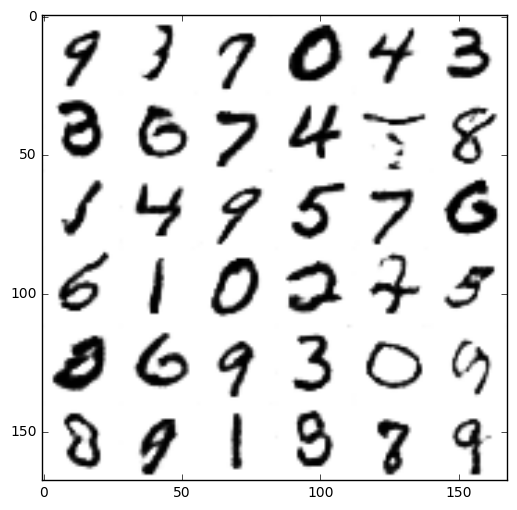

In [11]:
#Testing
#Generate images from noise, using the generator network
n = 6
canvas = np.empty((28*n, 28*n))

for i in range(n):
    #Noise input
    z = np.random.uniform(-1.0, 1.0, size=[n, noise_dim])
    
    #Generate image from noise
    g = sess.run(gen_sample, feed_dict={noise_input: z, is_training:False})
    
    #Rescale values to the original [0,1] (from tanh->[-1,1])
    g = (g+1.0) /2.0
    
    #Reverse colors for better display
    g = -1 * (g-1)
    
    for j in range(n):
        #Draw the generated digits
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = g[j].reshape([28,28])
        
plt.figure(figsize=(n,n))
plt.imshow(canvas, origin='upper', cmap='gray')
plt.show()